In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import torch
import pandas as pd
import seaborn as sns
import numpy as np
from mpl_toolkits.basemap import Basemap
import geopandas as gpd
from esda.moran import Moran
from libpysal.weights import KNN
from eval.metrics import *
from eval.plot import *
import data.valid_crd as valid_crd
import glob
import os
import yaml
import data.helper as helper

In [2]:
## loading bias corrected ensemble average

xt_ensemble = xr.open_dataset('/pscratch/sd/k/kas7897/cmip6/ensemble/1979_2000/2001_2014/dCLIMAD-BA (0.5Q-Livneh)/precipitation/ensemble.nc')

In [11]:
test_period = [2001, 2014]
exps  = ['7f6b6147', '01f207a2', '3e1d3c5b', '748c5922', 'a7d64b57', '71f57da0']
testep = [50, 150, 50, 150, 100, 100]


def load_model_run(run_id, est_period, epoch=None, base_dir='/pscratch/sd/k/kas7897/diffDownscale/jobs'):
    run_path = helper.load_run_path(run_id, base_dir)

    flat_dir = os.path.join(run_path, f"{test_period[0]}_{test_period[1]}")

    # Check which structure exists
    data_path = flat_dir
    config_path = os.path.join(run_path, 'train_config.yaml')

    x = torch.load(os.path.join(data_path, 'x.pt'), map_location='cpu').squeeze(-1).numpy()
    x[x<0.254] = 0 
    y = torch.load(os.path.join(data_path, 'y.pt'), map_location='cpu').squeeze(-1).numpy()
    y[y<0.254] = 0
    time = torch.load(os.path.join(data_path, 'time.pt'), map_location='cpu')

    xt = None
    if epoch is not None:
        xt_path = os.path.join(data_path, f'ep{epoch}', 'xt.pt')
        if os.path.exists(xt_path):
            xt = torch.load(xt_path, map_location='cpu')
        xt[xt<0.254] = 0

    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)

    return {
        'run_path': run_path,
        'x': x,
        'y': y,
        'time': time,
        'xt': xt,
        'config': config
    }

models = []
for i in range(len(exps)):
    model = load_model_run(exps[i], test_period, epoch=testep[i])
    models.append(model)

In [12]:
valid_coords = []
loca_all = []
QM_all = []

for i in range(len(models)):
    
    cmip6_dir = models[i]['config']['cmip_dir']
    clim = models[i]['config']['clim']
    ref = models[i]['config']['ref']
    train_period = [models[i]['config']['train_start'], models[i]['config']['train_end']]


    ds_sample = xr.open_dataset(f"{cmip6_dir}/{clim}/historical/precipitation/clipped_US.nc")

    shapefile_path = None if not  models[i]['config']['spatial_test']  else models[i]['config']['shapefile_filter_path']
    
    try:
        spatial_extent = models[i]['config']['spatial_extent_test']
    except:
        spatial_extent = models[i]['config']['spatial_extent_val']

    valid_coords.append(valid_crd.valid_lat_lon(ds_sample, var_name='pr', shapefile_path=shapefile_path, attrList=spatial_extent))


    #loading loca

    loca = xr.open_dataset(f'{cmip6_dir}/{clim}/historical/precipitation/loca/coarse_USclip.nc')
    loca = loca['pr'].sel(lat=xr.DataArray(valid_coords[i][:, 0], dims='points'),
                                        lon=xr.DataArray(valid_coords[i][:, 1], dims='points'),
                                        method='nearest')
    loca = loca.sel(time =slice(f'{test_period[0]}', f'{test_period[1]}')).values

    #unit conversion
    loca_all.append(loca*86400)



    # if 'QM' in method_names:
    QM_bench = f'benchmark/QuantileMapping/conus/{clim}-{ref}/{train_period}_historical_{test_period}.pt'
    QM_debiased = torch.load(QM_bench, weights_only=False).squeeze(-1)
    QM_all.append(QM_debiased*86400)

In [13]:
## this block filters 'y' based on 'x' calender
counter = 0
for model in models:
    time = model['time']
    
    x_time_np = np.array([pd.Timestamp(str(t)) for t in time])
    x_time_np = np.array([pd.Timestamp(t).replace(hour=0, minute=0, second=0) for t in x_time_np], dtype='datetime64[D]')
    # Generate a daily time array following the standard Gregorian calendar
    y_time = pd.date_range(start=f"{test_period[0]}-01-01", end=f"{test_period[1]}-12-31", freq="D")

    # Convert to NumPy array for indexing and comparison
    y_time_np = y_time.to_numpy()

    # Find indices where observed time matches model time
    matched_indices = np.where(np.isin(y_time_np, x_time_np))[0]

    model['y'] = model['y'][matched_indices,:]
    model['x_time_np'] = x_time_np

    loca_all[counter] = loca_all[counter][matched_indices, :]
    counter+=1

# ref_eval_data = models[exps.index(ref_eval)]['y']






In [14]:
cities = {
    "Pittsburgh": [40.437, -80.079],
    "Phoenix": [33.431, -112.008],
    "ARM site": [36.608, -97.488],
    "Sioux City": [42.387, -96.369],
    "Boulder": [39.998, -105.268],
    "Birmingham": [33.568, -86.751],
    "Ft Logan": [46.543, -110.902],
    "Seattle": [47.545, -122.243],
    "Yosemite": [37.749, -119.590],
    "Orlando": [28.450, -81.741],
}

# Convert to array
city_names = list(cities.keys())
city_coords = np.array(list(cities.values()))  # shape (10, 2)

# Assuming valid_coords is already loaded as a numpy array (lat, lon)
# Compute distances between each city and all valid_coords
def find_nearest_indices(city_coords, valid_coords):
    nearest_indices = []
    nearest_coords = []

    for coord in city_coords:
        # Broadcasting subtraction
        dists = np.linalg.norm(valid_coords - coord, axis=1)
        idx = np.argmin(dists)
        nearest_indices.append(idx)
        nearest_coords.append(valid_coords[idx])

    return nearest_indices, np.array(nearest_coords)

# Call the function
indices_coords = []
for coords in valid_coords:
    indices_coords.append(find_nearest_indices(city_coords, coords))

In [32]:
annual_total_x_local = []
annual_total_xt_local = []
annual_total_y_local = []
annual_total_loca_local = []

for i in range(len(cities)):
    annual_total_x = []
    annual_total_y = []
    annual_total_xt = []
    annual_total_loca = []

    for j in range(len(models)):
        loc = indices_coords[j][0][i]

        annual_total_x.append(calculate_annual_total(models[j]['x'], models[j]['x_time_np'])[:,loc])
        annual_total_y.append(calculate_annual_total(models[j]['y'], models[j]['x_time_np'])[:,loc])
        annual_total_xt.append(calculate_annual_total(models[j]['xt'], models[j]['x_time_np'])[:,loc])
        annual_total_loca.append(calculate_annual_total(loca_all[j], models[j]['x_time_np'])[:,loc])

    annual_total_x_local.append(np.array(annual_total_x).T)
    annual_total_xt_local.append(np.array(annual_total_xt).T)
    annual_total_y_local.append(np.array(annual_total_y).T)
    annual_total_loca_local.append(np.array(annual_total_loca).T)




In [36]:
annual_total_y_local[0].shape

(14, 6)

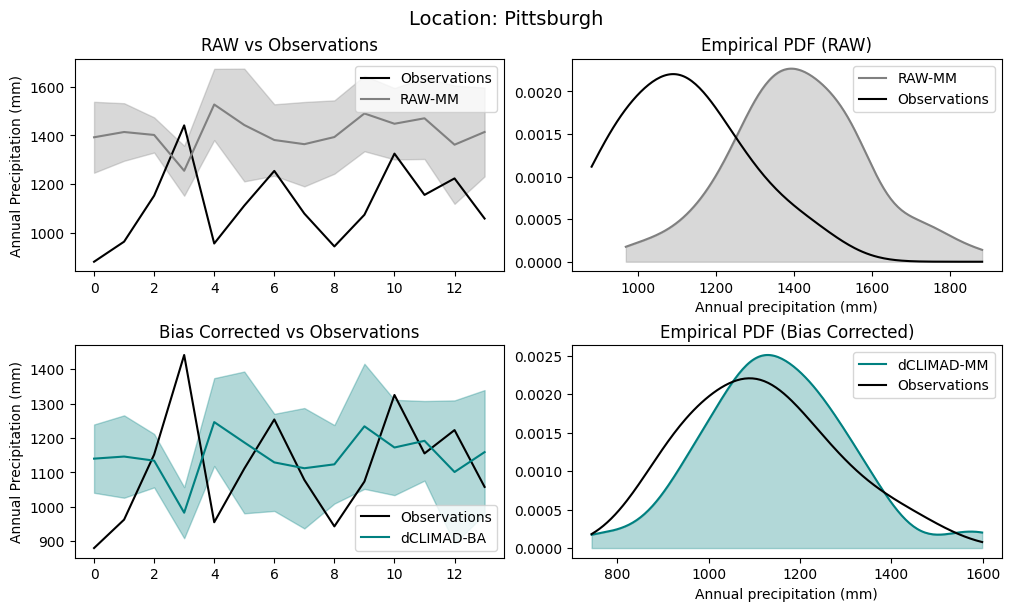

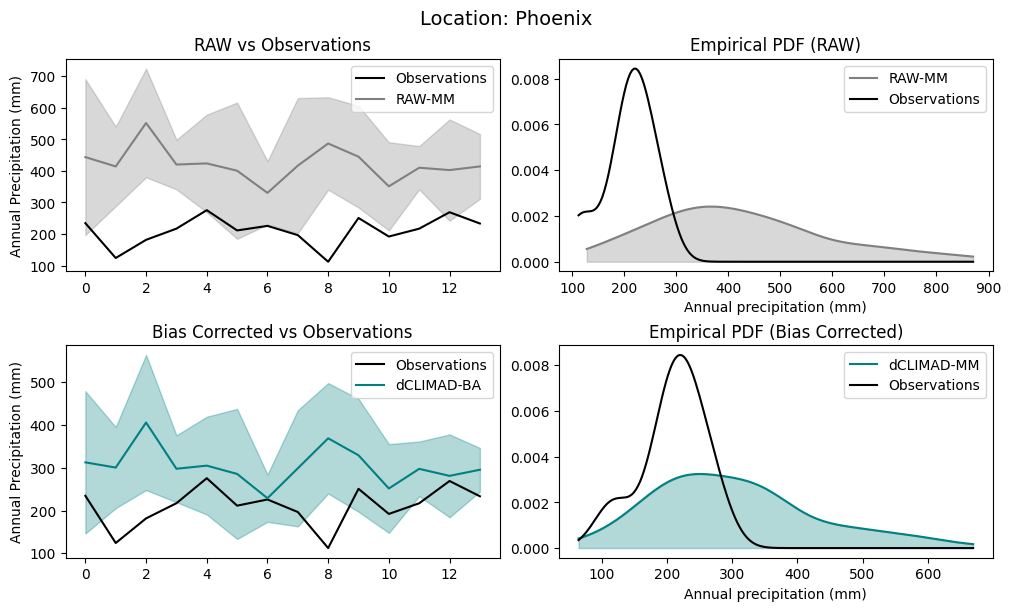

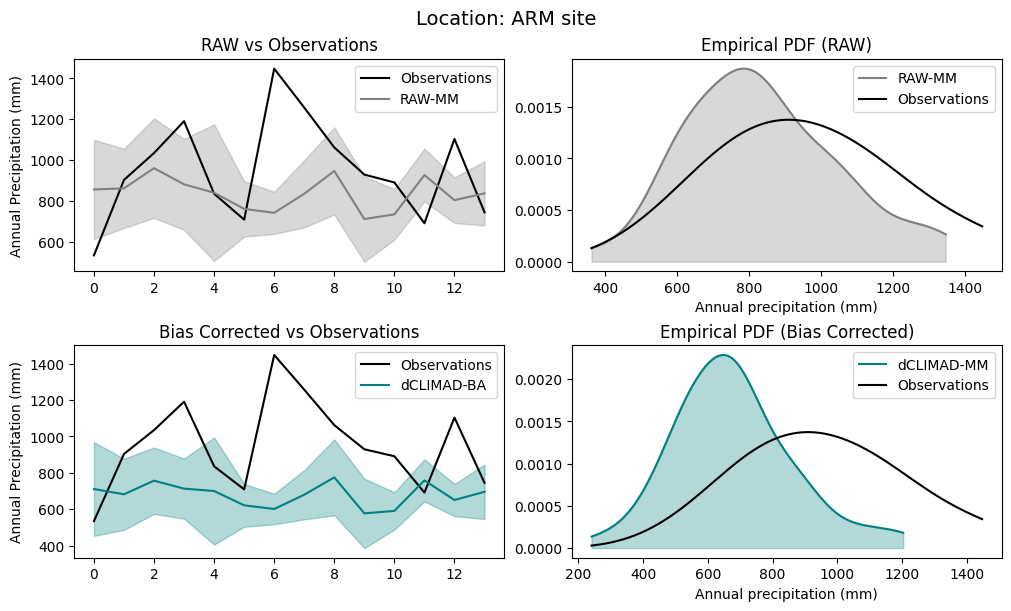

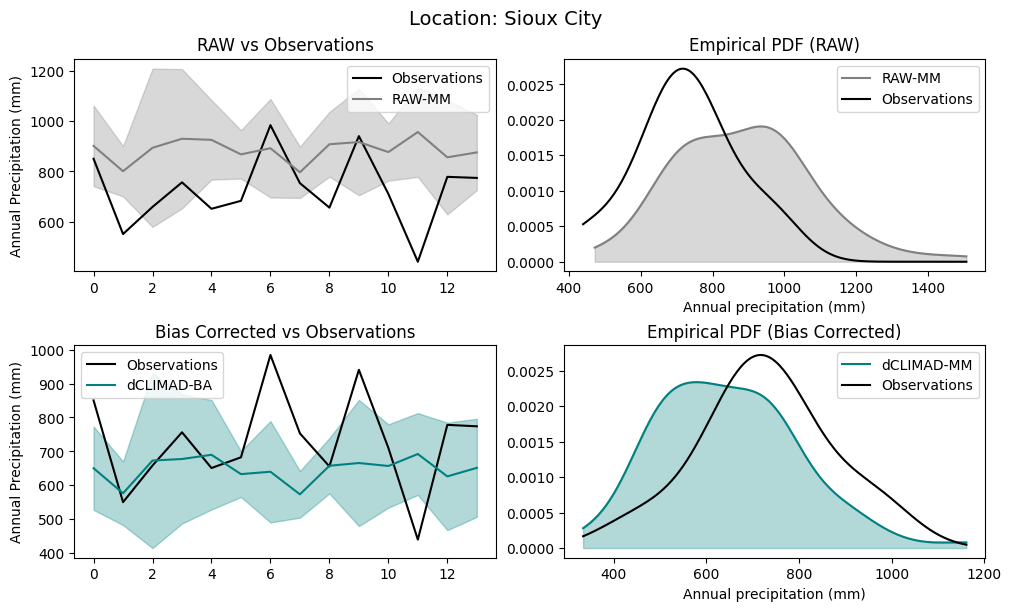

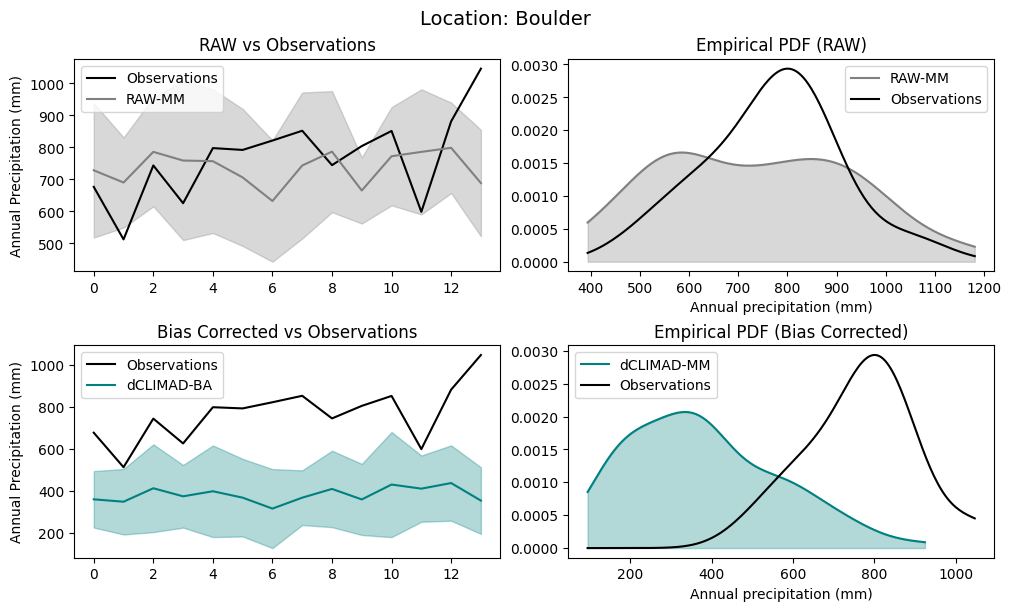

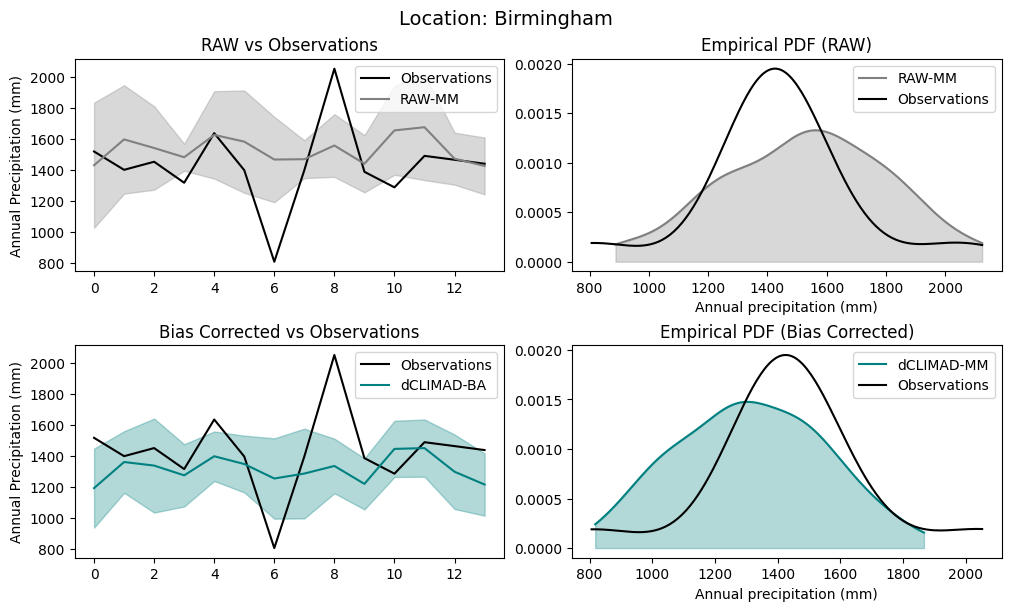

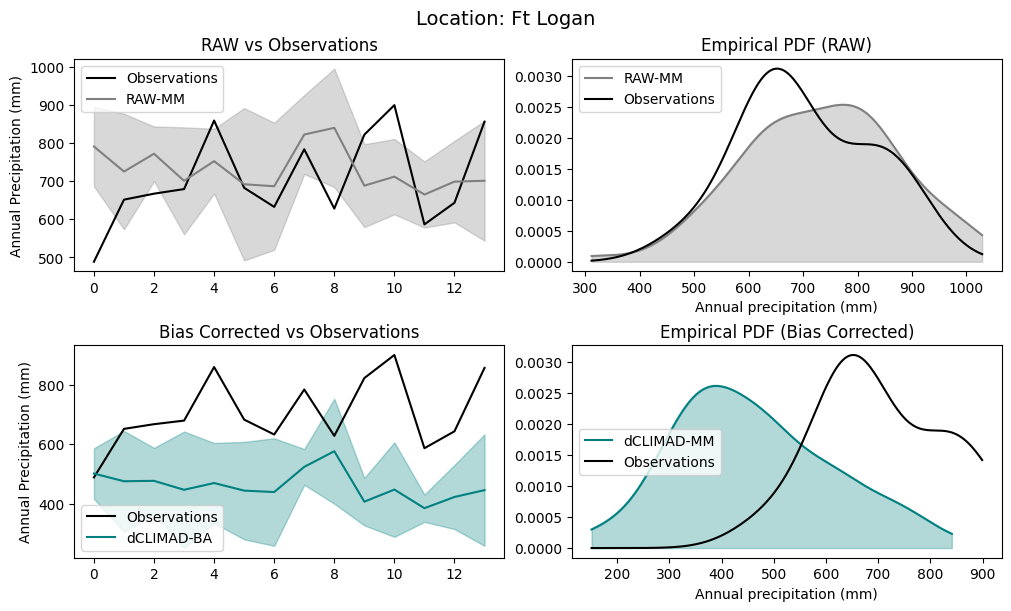

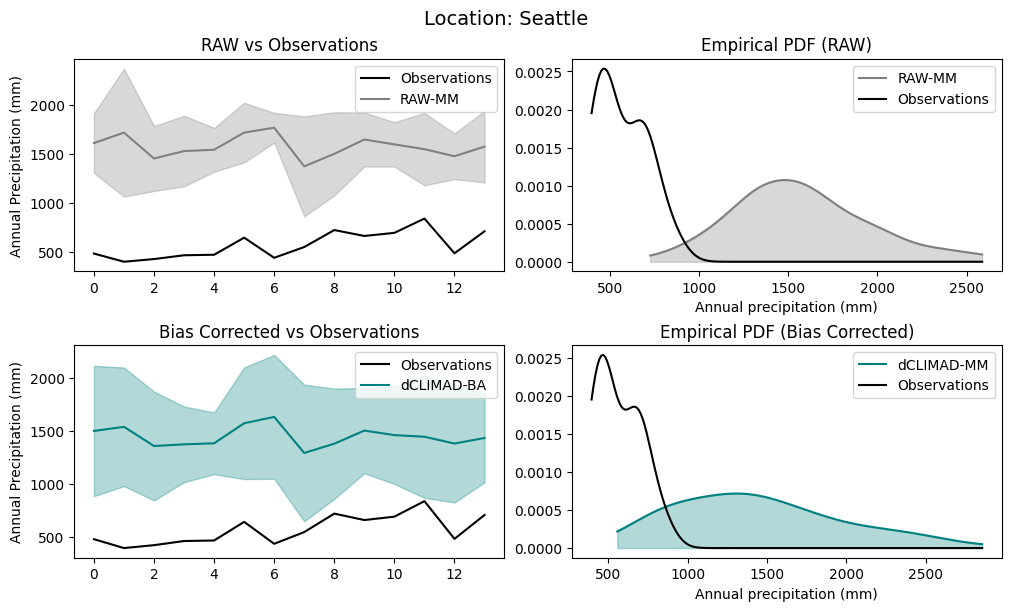

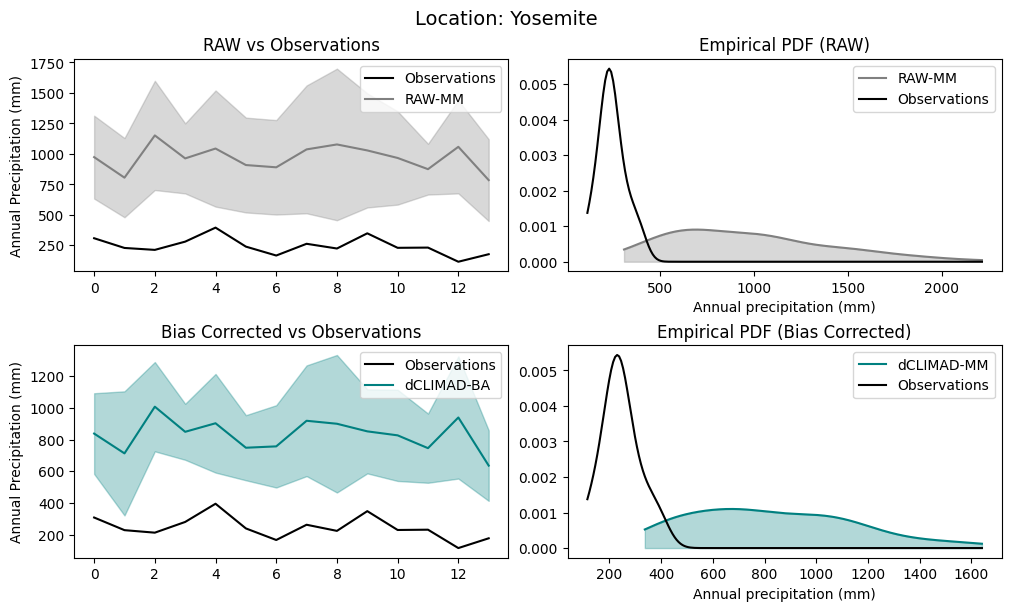

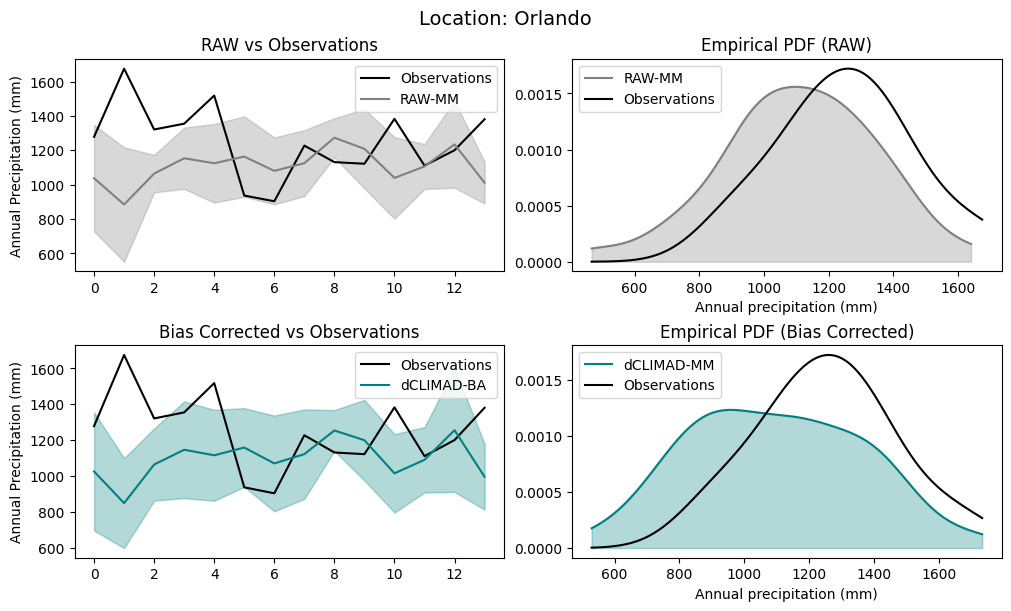

In [40]:
from scipy.stats import gaussian_kde

def plot_precip_analysis(obs_list, raw_list, bc_list, location_names):
    """
    obs_list, raw_list, bc_list are lists of arrays for each location:
        - obs: (n_years,)
        - raw: (n_years, n_models)
        - bc:  (n_years, n_models)
    """

  
    n_locations = len(location_names)
    for i in range(n_locations):
        obs = obs_list[i]
        raw = raw_list[i]
        bc = bc_list[i]

        years = np.arange(len(obs))

        obs = obs[:,0]

        # Ensemble mean and std
        raw_mean = raw.mean(axis=1)
        raw_std = raw.std(axis=1)
        bc_mean = bc.mean(axis=1)
        bc_std = bc.std(axis=1)

        fig, axs = plt.subplots(2, 2, figsize=(10, 6), constrained_layout=True)

        # (a) RAW
        axs[0, 0].plot(years, obs, color='black', label='Observations')
        axs[0, 0].plot(years, raw_mean, color='gray', label='RAW-MM')
        axs[0, 0].fill_between(years, raw_mean - raw_std, raw_mean + raw_std, color='gray', alpha=0.3)
        axs[0, 0].set_ylabel("Annual Precipitation (mm)")
        axs[0, 0].set_title("RAW vs Observations")
        axs[0, 0].legend()

        # (b) Bias-Corrected
        axs[1, 0].plot(years, obs, color='black', label='Observations')
        axs[1, 0].plot(years, bc_mean, color='teal', label='dCLIMAD-BA')
        axs[1, 0].fill_between(years, bc_mean - bc_std, bc_mean + bc_std, color='teal', alpha=0.3)
        axs[1, 0].set_ylabel("Annual Precipitation (mm)")
        axs[1, 0].set_title("Bias Corrected vs Observations")
        axs[1, 0].legend()

        # KDE for RAW
        raw_flat = raw.flatten()
        density_raw = gaussian_kde(raw_flat)
        xs_raw = np.linspace(raw_flat.min(), raw_flat.max(), 200)
        axs[0, 1].fill_between(xs_raw, density_raw(xs_raw), color='gray', alpha=0.3)
        axs[0, 1].plot(xs_raw, density_raw(xs_raw), color='gray', label='RAW-MM')
        density_obs = gaussian_kde(obs)
        xs_obs = np.linspace(min(obs.min(), raw_flat.min()), max(obs.max(), raw_flat.max()), 200)
        axs[0, 1].plot(xs_obs, density_obs(xs_obs), color='black', label='Observations')
        axs[0, 1].set_title("Empirical PDF (RAW)")
        axs[0, 1].set_xlabel("Annual precipitation (mm)")
        axs[0, 1].legend()

        # KDE for Bias Corrected
        bc_flat = bc.flatten()
        density_bc = gaussian_kde(bc_flat)
        xs_bc = np.linspace(bc_flat.min(), bc_flat.max(), 200)
        axs[1, 1].fill_between(xs_bc, density_bc(xs_bc), color='teal', alpha=0.3)
        axs[1, 1].plot(xs_bc, density_bc(xs_bc), color='teal', label='dCLIMAD-MM')
        density_obs = gaussian_kde(obs)
        xs_obs = np.linspace(min(obs.min(), bc_flat.min()), max(obs.max(), bc_flat.max()), 200)
        axs[1, 1].plot(xs_obs, density_obs(xs_obs), color='black', label='Observations')
        axs[1, 1].set_title("Empirical PDF (Bias Corrected)")
        axs[1, 1].set_xlabel("Annual precipitation (mm)")
        axs[1, 1].legend()

        fig.suptitle(f"Location: {location_names[i]}", fontsize=14)
        plt.show()

plot_precip_analysis(annual_total_y_local, annual_total_x_local, annual_total_xt_local, list(cities.keys()))